# Imports and data

In [21]:
import argparse
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from utils import *
from classifiers import *
from preprocess import *
import matplotlib.pyplot as plt
import plotly.express as px

In [13]:
seed = 42
random.seed(seed)
analyzer = 'word'
raw = pd.read_csv('../data/dataset.csv')
voc_size = 1

# Split

In [3]:
# list with all the languages (unique)
languages = set(raw['language']) 

# Split Train and Test sets
X=raw['Text']
y=raw['language']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [4]:
# save the raw test set to check bad labaled data
x_test_raw_2 = X_test

In [12]:
# Plot of the distribution of the languages in the dataset
#raw['language'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(10, 10))
countsDf = pd.DataFrame(raw['language'].value_counts()).reset_index()
countsDf.columns = ['Language', 'Total']
fig = px.pie(countsDf, values='Total', names='Language', title='Distribution of the languages in the dataset')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(autosize=False, width=800, height=800, showlegend=False)
fig.show()

# Procesar words

In [41]:
def preprocess(sentence, labels):
    '''
    Task: Given a sentence apply all the required preprocessing steps
    to compute train our classifier, such as sentence splitting, 
    tokenization or sentence splitting.

    Input: Sentence in string format
    Output: Preprocessed sentence either as a list or a string
    '''
    # Place your code here
    # Keep in mind that sentence splitting affectes the number of sentences
    # and therefore, you should replicate labels to match.
    tokensToRemove = ["[","]","《","》"]
    #
    for s,l in zip(sentence,labels):
        # Remove strange tokens
        for t in tokensToRemove:
            s = s.replace(t, "")

        # Split sentence in more subsentences "，"nltk
        parts = s.split(".")
        if(len(parts)>1):
            print(parts)
    return sentence,labels

In [42]:
# Preprocess text (Word granularity only)
if analyzer == 'word':
    X_train, y_train = preprocess(X_train,y_train)
    X_test, y_test = preprocess(X_test,y_test)

# Vectorize the text

In [42]:
# Vectorize the text
unigramVectorizer = CountVectorizer(analyzer='char',max_features=500,ngram_range=(1,1))
X_unigram_train_raw = unigramVectorizer.fit_transform(X_train)
X_unigram_test_raw = unigramVectorizer.transform(X_test)
unigramFeatures = unigramVectorizer.get_feature_names()
print('length of the vector:' + str(len(unigramFeatures)))

# change variables names
features = unigramFeatures      # features names
X_train_raw = X_unigram_train_raw
X_test_raw = X_unigram_test_raw

# for i in X_unigram_train_raw.toarray():
#     print(i)

length of the vector:500


c:\Users\jordi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
# # Uni- & Bi-Gram Mixture CountVectorizer for top 1% features
# top1PrecentMixtureVectorizer = CountVectorizer(analyzer='char', ngram_range=(1,1), min_df=1e-2)
# X_top1Percent_train_raw = top1PrecentMixtureVectorizer.fit_transform(X_train)
# X_top1Percent_test_raw = top1PrecentMixtureVectorizer.transform(X_test)

In [44]:
print('========')
print('Number of tokens in the vocabulary:', len(features))
print('Coverage: ', compute_coverage(features, X_test.values, analyzer=analyzer))
print('========')

Number of tokens in the vocabulary: 500
Coverage:  0.039077894439904254


# Significance per language

In [45]:
# Aggregate Unigrams per language   (funcio agafada del kaggle)
def train_lang_dict(X_raw_counts, y_train):
    '''Returns a dictionary with the relative frequency of each feature per language.'''

    lang_dict = {}
    for i in range(len(y_train)):
        lang = y_train[i]
        v = np.array(X_raw_counts[i])
        if not lang in lang_dict:
            lang_dict[lang] = v
        else:
            lang_dict[lang] += v
            
    # to relative
    for lang in lang_dict:
        v = lang_dict[lang]
        lang_dict[lang] = v / np.sum(v)
        
    return lang_dict

# Collect relevant chars per language  (funcio agafada del kaggle i modificada)
def getRelevantCharsPerLanguage(features, language_dict, significance=1e-5):
    relevantCharsPerLanguage = {}
    relevantCharsPerLanguage_w_significance = {}

    for lang in languages:
        chars = []
        significance_chars = {}
        relevantCharsPerLanguage[lang] = chars
        relevantCharsPerLanguage_w_significance[lang] = significance_chars
        v = language_dict[lang]
        for i in range(len(v)):
            if v[i] > significance:
                chars.append(features[i])
                significance_chars[features[i]] = v[i]
    return relevantCharsPerLanguage, relevantCharsPerLanguage_w_significance

language_dict_unigram = train_lang_dict(X_unigram_train_raw.toarray(), y_train.values)

relevantCharsPerLanguage, relevantCharsPerLanguage_significance = getRelevantCharsPerLanguage(unigramFeatures, language_dict_unigram)

# Convert to dic
languages_num_ngrams = {}
for lang in languages:    
    languages_num_ngrams[lang] = len(relevantCharsPerLanguage[lang])

# Order a dictionary by value
def sortDictByValue(d):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

languages_num_ngrams = sortDictByValue(languages_num_ngrams)

languages_num_ngrams

# plot an histogram with the number of unigrams per language
# plt.bar(languages_num_ngrams.keys(), languages_num_ngrams.values(), color='g')
# plt.show()

{'Dutch': 46,
 'English': 47,
 'Spanish': 53,
 'Portugese': 55,
 'French': 55,
 'Indonesian': 64,
 'Swedish': 66,
 'Russian': 72,
 'Estonian': 77,
 'Turkish': 80,
 'Arabic': 83,
 'Romanian': 84,
 'Persian': 86,
 'Latin': 86,
 'Tamil': 88,
 'Hindi': 90,
 'Urdu': 104,
 'Thai': 117,
 'Pushto': 125,
 'Chinese': 185,
 'Japanese': 203,
 'Korean': 217}

In [46]:
# Plots de significancia de los unigramas por idioma
for i in relevantCharsPerLanguage_significance.keys():
    relevantCharsPerLanguage_significance[i] = {k: v for k, v in sorted(relevantCharsPerLanguage_significance[i].items(), key=lambda item: item[1], reverse=True)}


# for i in relevantCharsPerLanguage_significance.keys():
#     # add title
#     plt.xlabel("Unigrams")
#     plt.ylabel("Significance")
#     plt.title(i)
#     plt.plot(relevantCharsPerLanguage_significance[i].keys(), relevantCharsPerLanguage_significance[i].values(), color='b')
#     plt.savefig('C:/Users/jordi/Documents/GitHub/MUD_Labs_Git/LangDetect/figures/'+i+'.jpg')
#     # plt.show()
#     # save figure


# Classifier

In [47]:
#Apply Classifier  
X_train, X_test = normalizeData(X_train_raw, X_test_raw)
y_predict = applyNaiveBayes(X_train, y_train, X_test)

print('========')
print('Prediction Results:')    
plot_F_Scores(y_test, y_predict)
print('========')

Prediction Results:
F1: 0.9602272727272727 (micro), 0.9622050216794633 (macro), 0.9620524366626872 (weighted)


# Analize results

In [ ]:
# detect wrong predicted data
for i in range(len(y_predict)):
    if y_test.iloc[i] != y_predict[i] and (y_test.iloc[i] == 'Dutch' and y_predict[i] == 'English') or (y_test.iloc[i] == 'English' and y_predict[i] == 'Dutch'):
        print('Predicted: ', y_predict[i], ' Actual: ', y_test.iloc[i], ' Text: ', x_test_raw_2.iloc[i])
        print('')

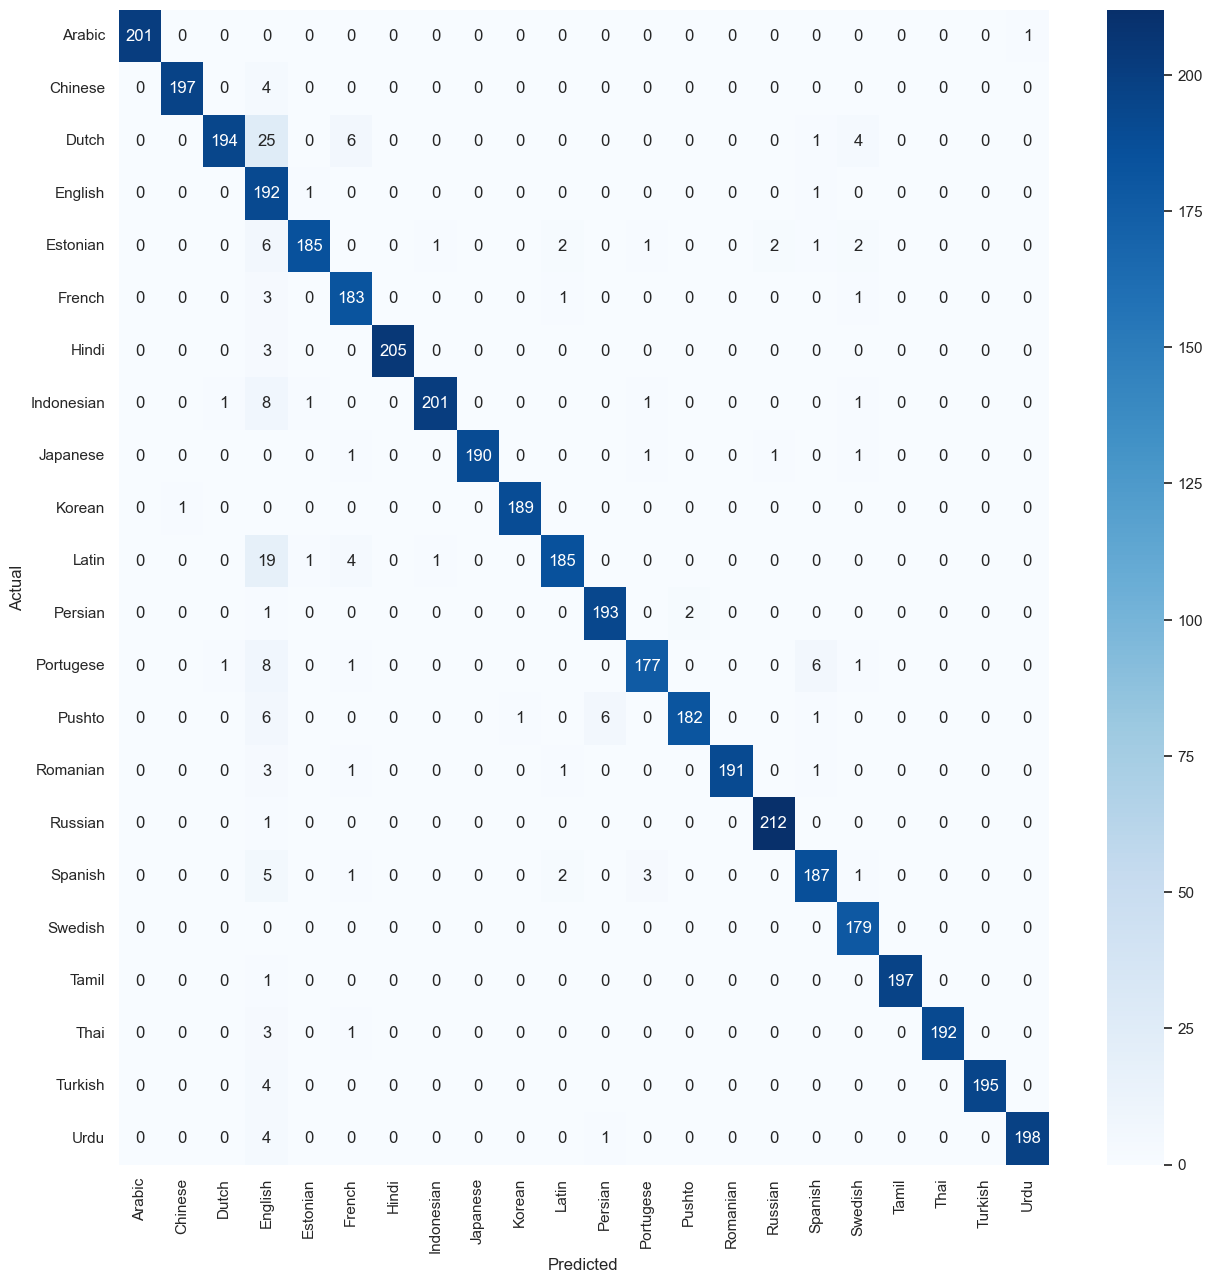

In [58]:
# plot confusion matrix
plot_Confusion_Matrix(y_test, y_predict, "Blues") 

# PCA analize

PCA and Explained Variance:
Variance explained by PCA: [0.31489875 0.14208597]


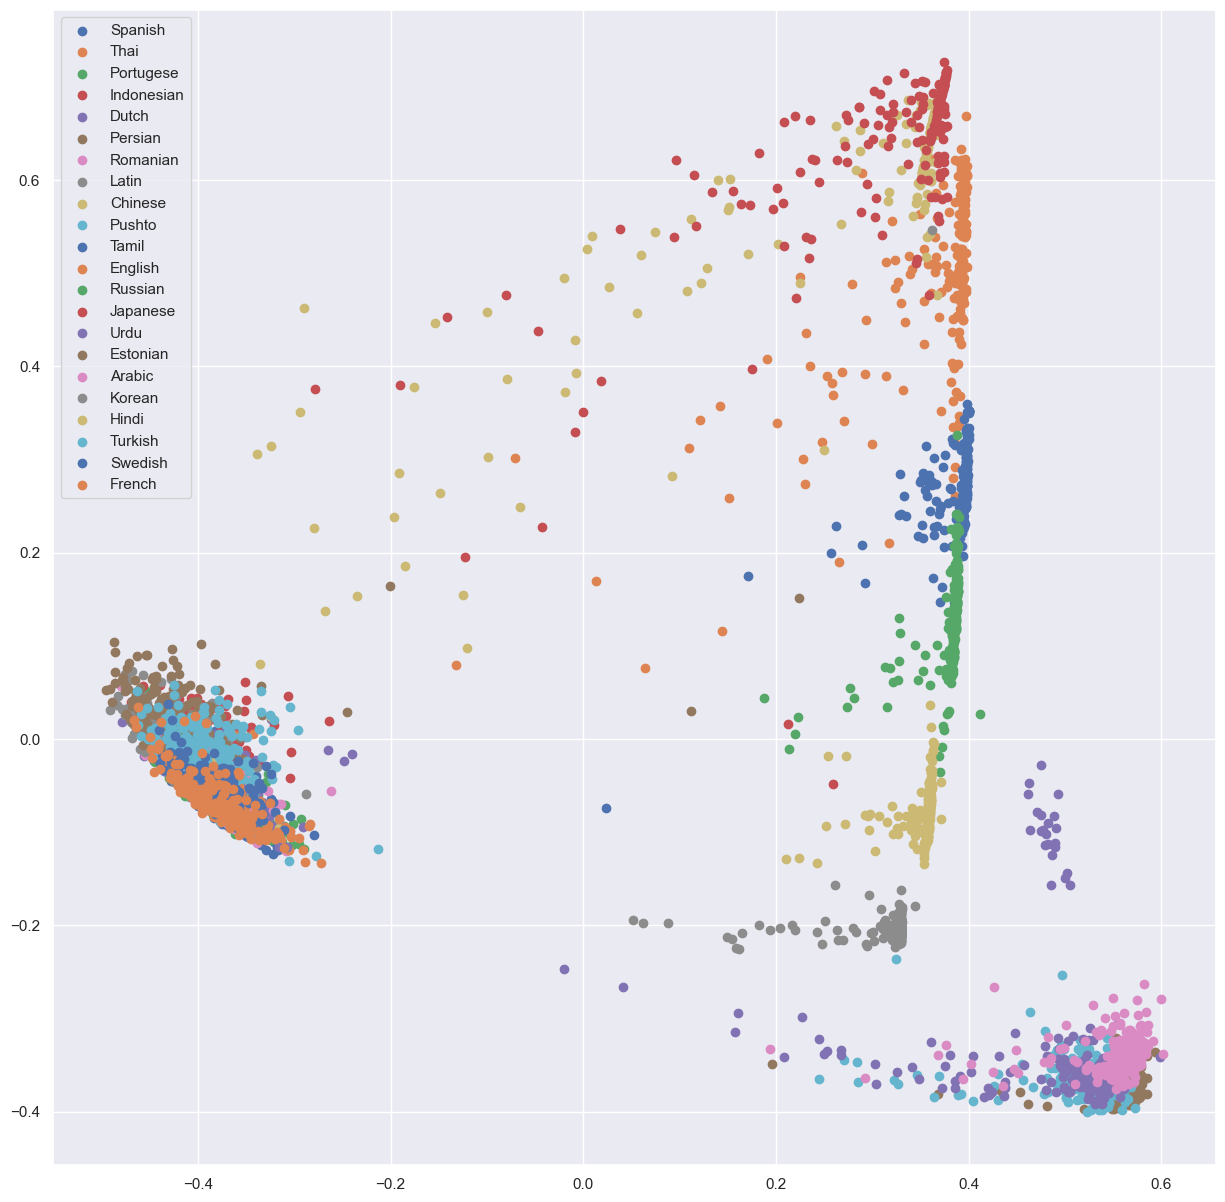

In [59]:
#Plot PCA
print('========')
print('PCA and Explained Variance:') 
plotPCA(X_train, X_test,y_test, languages) 
print('========')


# Plots performance of different models

In [25]:
unigrams_plot_f1 = {'150':0.937, '250': 0.959,'500': 0.96022,'1000':0.95522,'2000':0.94659,'4000': 0.93409,'6816': 0.9245}
unigrams_plot_coverage = {'150':0.8560, '250': 0.9243, '500': 0.9603, '1000': 0.98085, '2000':0.9928, '4000': 0.9986, '6816': 0.9997}

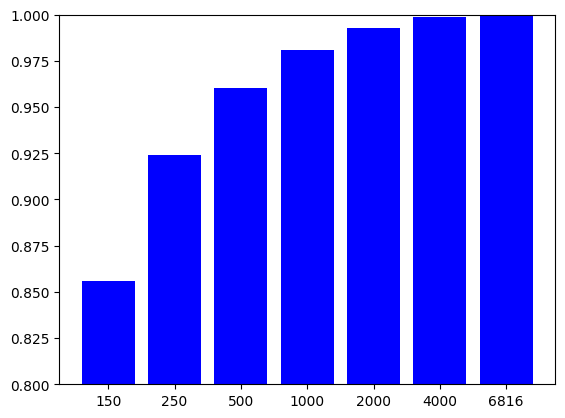

In [29]:
# plot an histogram with unigrams_plot with the y axis from 0.8 to 1
plt.bar(unigrams_plot_coverage.keys(), unigrams_plot_coverage.values(), color='b')
plt.ylim(0.8, 1)
plt.show()

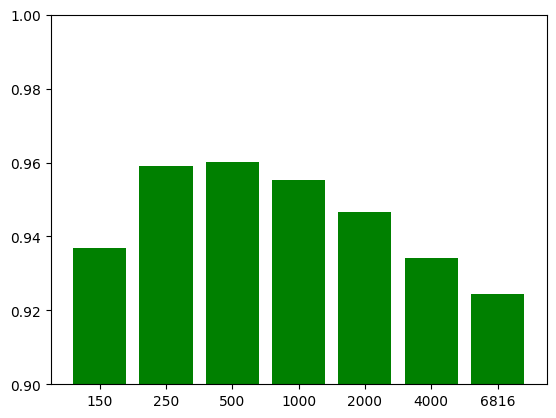

In [28]:
# plot an histogram with unigrams_plot with the y axis from 0.8 to 1
plt.bar(unigrams_plot_f1.keys(), unigrams_plot_f1.values(), color='g')
plt.ylim(0.9, 1)
plt.show()